In [3]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import time
import re
import seaborn
from lxml import html
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

Получаем 250 самых топовых фильмов

In [2]:
url = 'http://www.imdb.com/chart/top'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')

Парсим страницу с фильмами и получаем грязные данные с


1.   Названием фильма
2.   Рейтингом
3.   Командой 
4.   Ссылкой на основную страницу




In [3]:
movies = soup.select('td.titleColumn')
links = [a.attrs.get('href') for a in soup.select('td.titleColumn a')]
crew = [a.attrs.get('title') for a in soup.select('td.titleColumn a')]
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]

In [4]:
data_frame = {
    "movies": movies,
    "ratings": ratings,
    "crew": crew,
    "links": links
}

data = pd.DataFrame(data_frame)
data

,movies,ratings,crew,links
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.235294728575104,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.156163976919544,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.98960502345779,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.984051803301583,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.951091683269263,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/
...,...,...,...,...
245,"[\n 246.\n , [Дерсу Узала], \n, [(19...",8.006442773698145,"Akira Kurosawa (dir.), Maksim Munzuk, Yuriy So...",/title/tt0071411/
246,"[\n 247.\n , [Стальной гигант], \n, ...",8.005102583402028,"Brad Bird (dir.), Eli Marienthal, Harry Connic...",/title/tt0129167/
247,"[\n 248.\n , [Прислуга], \n, [(2011)...",8.00500685241788,"Tate Taylor (dir.), Viola Davis, Emma Stone",/title/tt1454029/
248,"[\n 249.\n , [Аладдин], \n, [(1992)]...",8.004989589838072,"Ron Clements (dir.), Scott Weinger, Robin Will...",/title/tt0103639/


Несколько функциий для преобзразования грязных заголовков с названием фильмов


In [5]:
def process_text_mv(text):
    data = text.get_text().split("\n")
    return data[2].strip()

In [6]:
def process_text_year(text):
    data = text.get_text().split("\n")
    return data[3].strip()[1:-1]

In [7]:
data["title"] = data.movies.apply(process_text_mv)
data["year"] = data.movies.apply(process_text_year)

In [8]:
data.head()

,movies,ratings,crew,links,title,year
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.235294728575104,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.156163976919544,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.98960502345779,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.984051803301583,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.951091683269263,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957


In [9]:
data.crew[1]

'Francis Ford Coppola (dir.), Marlon Brando, Al Pacino'

Задача 1. Получить список всех участников команд (убрать постфикс `(dir.)` у директоров). Найти количество уникальных имен.

In [10]:
people = []

for crew in data.crew:
    people.extend([x.replace(' (dir.)', '') for x in crew.split(', ')])

print(f'Количество уникальны имён равно {len(set(people))}')

Количество уникальны имён равно 527


Задача 2.
Получить список всех директоров. Построить распределение (визуализация обязательна) и найти директора(ов), у которого(ых) больше всего фильмов в топе.

**NB**: Здесь и дальше для визуализации _распределения_ я выбираю гистограмму, а не столбчатую диаграмму, потому что, по-моему, она гораздо лучше отражает то, что можно было бы назвать _распределением_. Везде, где это хоть сколько-то разумно, я добавляю функцию оценки плотности распределения (`kde=true`).

Директоры с наибольшим числом фильмов -- Christopher Nolan, Steven Spielberg, Martin Scorsese, Akira Kurosawa, Stanley Kubrick


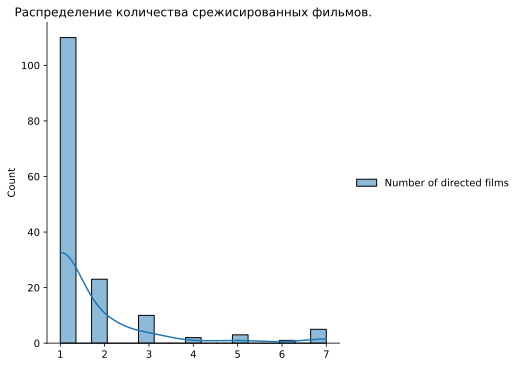

In [11]:
dirs = []

for crew in data.crew:
    dirs.extend([x.replace(' (dir.)', '') for x in crew.split(', ') if ' (dir.)' in x])

df = pd.DataFrame(Counter(dirs).most_common(),
                  columns=['name', 'Number of directed films'])

seaborn.displot(df, kde=True);
plt.title('Распределение количества срежисированных фильмов.');

print('Директоры с наибольшим числом фильмов --',
      ', '.join(df[df['Number of directed films'] == max(df['Number of directed films'])].name))

Задача 3. Найти участника(ов) команд, у которого(ых) больше всего фильмов в топе.

Участники команд с наибольшим числом фильмов -- Robert De Niro


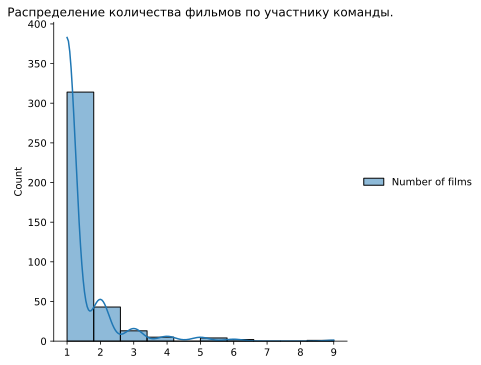

In [12]:
actors = []

for crew in data.crew:
    actors.extend([x for x in crew.split(', ') if ' (dir.)' not in x])

df = pd.DataFrame(Counter(actors).most_common(),
                  columns=['name', 'Number of films'])

seaborn.displot(df, kde=True);
plt.title('Распределение количества фильмов по участнику команды.');

print('Участники команд с наибольшим числом фильмов --',
      ', '.join(df[df['Number of films'] == max(df['Number of films'])].name))


Задача 4. Построить распределение топовых фильмов по годам



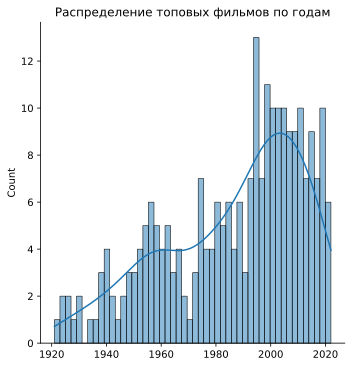

In [13]:
# Количество bins можно поставить другое по желанию

seaborn.displot([int(x) for x in data.year], kde=True, bins=50);
plt.title('Распределение топовых фильмов по годам');

Задача 5. Построить распределение топовых фильмов рейтингу:


*   Округлить до сотых и отрисовать
*   Округлить до десятых и отрисовать
*   Округлить до целых и отрисовать


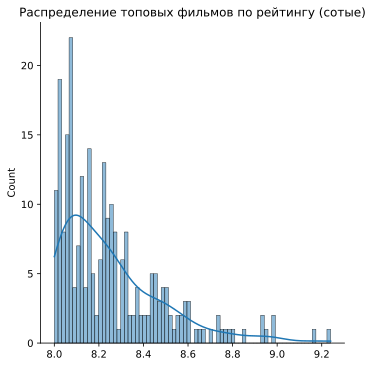

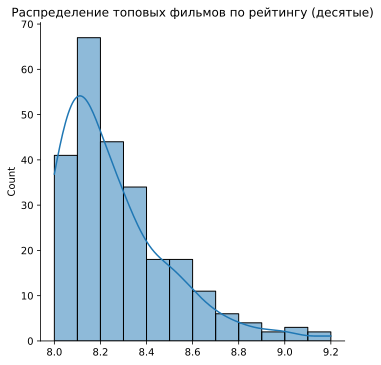

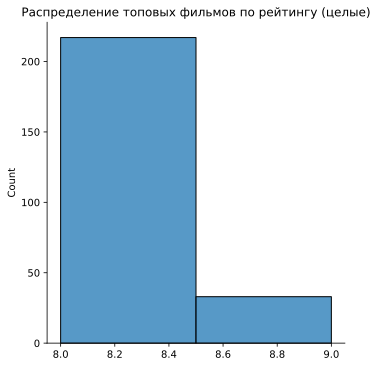

In [14]:
# сотые

ratings = [round(float(x), 2) for x in data.ratings]
seaborn.displot(ratings, kde=True, bins=len(set(ratings)));
plt.title('Распределение топовых фильмов по рейтингу (сотые)');


# десятые

ratings = [round(float(x), 1) for x in data.ratings]
seaborn.displot(ratings, kde=True, bins=len(set(ratings)));
plt.title('Распределение топовых фильмов по рейтингу (десятые)');

# целые

ratings = [round(float(x), 0) for x in data.ratings]
seaborn.displot(ratings, bins=len(set(ratings)));
plt.title('Распределение топовых фильмов по рейтингу (целые)');

Задача 6. Используйте ссылку `http://www.imdb.com/` и динамически добавляя ссылку на фильм из колонки `links` соберите описание фильмов. Пример поиска необходимого текст представлен ниже. Добавьте эту информацию в исходный датафрейм.

In [15]:
from fake_useragent import UserAgent
from tqdm.auto import tqdm


# без имитации браузера все страницы выдавали Forbidden
ua = UserAgent(verify_ssl=False).random

descriptions = []

for url in tqdm(data.links):
    film_url = f'http://www.imdb.com{url}'
    html_text = requests.get(film_url, headers={'User-Agent': ua}).text
    
    soup = BeautifulSoup(html_text, 'lxml')
    description = soup.find_all(attrs={"name": "description"})[0].get("content")
    
    descriptions.append(description)

  0%|          | 0/250 [00:00<?, ?it/s]

In [1]:
data['description'] = descriptions

NameError: name 'descriptions' is not defined


Задача 7. С помощью регулярных выражений найдите в текстах описания фильмов имена актеров, если это возможно (то есть - они там упоминаются). Добавьте эту информацию в датафрейм и посчитайте, для скольких фильмов получилось это сдлеать. Подсказка: перечисление актеров иногда начинается с with. 




In [17]:
data

,movies,ratings,crew,links,title,year,description
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.235294728575104,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994,Побег из Шоушенка: Directed by Frank Darabont....
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.156163976919544,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972,Крёстный отец: Directed by Francis Ford Coppol...
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.98960502345779,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008,Темный рыцарь: Directed by Christopher Nolan. ...
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.984051803301583,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974,Крёстный отец 2: Directed by Francis Ford Copp...
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.951091683269263,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957,12 рaзгневанных мужчин: Directed by Sidney Lum...
...,...,...,...,...,...,...,...
245,"[\n 246.\n , [Дерсу Узала], \n, [(19...",8.006442773698145,"Akira Kurosawa (dir.), Maksim Munzuk, Yuriy So...",/title/tt0071411/,Дерсу Узала,1975,Дерсу Узала: Directed by Akira Kurosawa. With ...
246,"[\n 247.\n , [Стальной гигант], \n, ...",8.005102583402028,"Brad Bird (dir.), Eli Marienthal, Harry Connic...",/title/tt0129167/,Стальной гигант,1999,Стальной гигант: Directed by Brad Bird. With J...
247,"[\n 248.\n , [Прислуга], \n, [(2011)...",8.00500685241788,"Tate Taylor (dir.), Viola Davis, Emma Stone",/title/tt1454029/,Прислуга,2011,Прислуга: Directed by Tate Taylor. With Emma S...
248,"[\n 249.\n , [Аладдин], \n, [(1992)]...",8.004989589838072,"Ron Clements (dir.), Scott Weinger, Robin Will...",/title/tt0103639/,Аладдин,1992,"Аладдин: Directed by Ron Clements, John Musker..."


In [2]:
exp = re.compile(r'[wW]ith((?: \w[\w-]*,?)+)')

actors_in_desc = []

for description in descriptions:
    names = exp.search(description)
    if not names:
        actors_in_desc.append(None)
        continue
    names = names.group(1).strip().split(',')
    names = [name.strip() for name in names]
    actors_in_desc.append(names)

NameError: name 're' is not defined

In [19]:
data['actors_in_desc'] = actors_in_desc

print(f'Найти данные об актёрах в описании получилось для {len([x for x in actors_in_desc if x])} фильмов.')

Найти данные об актёрах в описании получилось для 250 фильмов.


Задача 8. Распарсите исходную страницу с топ-250 фильмов и получите для каждого фильмов количество оценок. Пример текста в исходной странице:`9.2 based on 2,554,919 user ratings`. Из этого текста нужно достать = `2,554,919`. Подсказка: используя метод `find_all` с аргументом `attrs` в который нужно передать `{'class': 'ratingColumn imdbRating'}` от страници `http://www.imdb.com/chart/top`. Найдите 10 фильмов (вывести их название и кол-во оценок) у которых, самое большое количество оценок.





In [20]:
url = 'http://www.imdb.com/chart/top'
html_text = requests.get(url, headers={'User-Agent': ua}).text
soup = BeautifulSoup(html_text)
ratings = soup.find_all(attrs={'class': 'ratingColumn imdbRating'})

In [21]:
exp = re.compile(r'based on (.*) user ratings')

number_of_ratings = []

for rating in ratings:
    n = rating.strong['title']
    n = exp.search(n).group(1)
    number_of_ratings.append(int(n.replace(',', '')))

In [22]:
data['number_of_ratings'] = number_of_ratings
data.sort_values('number_of_ratings', ascending=False)[:10][['title', 'number_of_ratings']]

,title,number_of_ratings
0,Побег из Шоушенка,2672223
2,Темный рыцарь,2645081
13,Начало,2344567
11,Бойцовский клуб,2117660
10,Форрест Гамп,2072138
7,Криминальное чтиво,2047231
15,Матрица,1908661
8,Властелин колец: Братство кольца,1870868
1,Крёстный отец,1851996
6,Властелин колец: Возвращение короля,1841614


Задача 9. Постройте топ 10 слов, которые встречаются 

1.   в названии фильмов
2.   в описании фильмов
3.   в названии и в описании фильмов



In [24]:
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords

punctuation += '«»'
stops = stopwords.words('russian') + stopwords.words('english') + ['\'s']

title_words = []

# Я решил почистить от стоп-слов и пунктуации но можно этого не делать
# Чтобы оставить стоп-слова нужно убрать часть "and x.lower() not in stops"

for title in data.title:
    title_words.extend(
        [x for x in word_tokenize(title) if x.lower() not in punctuation and x.lower() not in stops]
    )

desc_words = []

for desc in data.description:
    desc_words.extend(
        [x for x in word_tokenize(desc) if x.lower() not in punctuation and x.lower() not in stops]
    )

In [25]:
def pretty_print_counter(cnter):
    for word in cnter.most_common(10):
        print(f'Слово "{word[0]}" встречается {word[1]} раз(а)')

print('Топ слов в названиях:')
pretty_print_counter(Counter(title_words))


# по-хорошему надо бы убирать из описаний упоминания режиссёров и актёров,
# но это требует дополнительных мер

print('\nТоп слов в описаниях:')
pretty_print_counter(Counter(desc_words))

print('\nТоп слов в названиях и описаниях:')
pretty_print_counter(Counter(title_words + desc_words))

Топ слов в названиях:
Слово "отец" встречается 3 раз(а)
Слово "2" встречается 3 раз(а)
Слово "Властелин" встречается 3 раз(а)
Слово "колец" встречается 3 раз(а)
Слово "Звёздные" встречается 3 раз(а)
Слово "войны" встречается 3 раз(а)
Слово "Эпизод" встречается 3 раз(а)
Слово "Большой" встречается 3 раз(а)
Слово "Крёстный" встречается 2 раз(а)
Слово "Темный" встречается 2 раз(а)

Топ слов в описаниях:
Слово "Directed" встречается 250 раз(а)
Слово "John" встречается 30 раз(а)
Слово "life" встречается 29 раз(а)
Слово "young" встречается 27 раз(а)
Слово "Robert" встречается 25 раз(а)
Слово "James" встречается 23 раз(а)
Слово "help" встречается 22 раз(а)
Слово "two" встречается 20 раз(а)
Слово "man" встречается 20 раз(а)
Слово "Tom" встречается 18 раз(а)

Топ слов в названиях и описаниях:
Слово "Directed" встречается 250 раз(а)
Слово "John" встречается 30 раз(а)
Слово "life" встречается 29 раз(а)
Слово "young" встречается 27 раз(а)
Слово "Robert" встречается 25 раз(а)
Слово "James" встречае


Задача 10*. Спарсить теги фильмов со страницы каждого фильма, так например для `The Godfather` ожидается получить список из `Crime, Drama`. (Можно увидеть эти теги по картинкой к фильму)

In [26]:
tags_by_film = []

for url in tqdm(data.links):
    film_url = f'http://www.imdb.com{url}'
    html_text = requests.get(film_url, headers={'User-Agent': ua}).text
    
    soup = BeautifulSoup(html_text, 'lxml')
    tags = soup.find_all('div', {'class': 'ipc-chip-list__scroller'})
    tags_by_film.append([tag.text for tag in tags[0].find_all('a')])

  0%|          | 0/250 [00:00<?, ?it/s]

In [27]:
data['tags'] = tags_by_film
data

,movies,ratings,crew,links,title,year,description,actors_in_desc,number_of_ratings,tags
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.235294728575104,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994,Побег из Шоушенка: Directed by Frank Darabont....,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",2672223,[Drama]
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.156163976919544,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972,Крёстный отец: Directed by Francis Ford Coppol...,"[Marlon Brando, Al Pacino, James Caan, Richard S]",1851996,"[Crime, Drama]"
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.98960502345779,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008,Темный рыцарь: Directed by Christopher Nolan. ...,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",2645081,"[Action, Crime, Drama]"
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.984051803301583,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974,Крёстный отец 2: Directed by Francis Ford Copp...,"[Al Pacino, Robert Duvall, Diane Keaton, Rober...",1268074,"[Crime, Drama]"
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.951091683269263,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957,12 рaзгневанных мужчин: Directed by Sidney Lum...,"[Martin Balsam, John Fiedler, Lee J]",789296,"[Crime, Drama]"
...,...,...,...,...,...,...,...,...,...,...
245,"[\n 246.\n , [Дерсу Узала], \n, [(19...",8.006442773698145,"Akira Kurosawa (dir.), Maksim Munzuk, Yuriy So...",/title/tt0071411/,Дерсу Узала,1975,Дерсу Узала: Directed by Akira Kurosawa. With ...,"[Yuriy Solomin, Maksim Munzuk, Mikhail Bychkov...",30319,"[Adventure, Biography, Drama]"
246,"[\n 247.\n , [Стальной гигант], \n, ...",8.005102583402028,"Brad Bird (dir.), Eli Marienthal, Harry Connic...",/title/tt0129167/,Стальной гигант,1999,Стальной гигант: Directed by Brad Bird. With J...,"[Jennifer Aniston, Harry Connick Jr]",199631,"[Animation, Action, Adventure]"
247,"[\n 248.\n , [Прислуга], \n, [(2011)...",8.00500685241788,"Tate Taylor (dir.), Viola Davis, Emma Stone",/title/tt1454029/,Прислуга,2011,Прислуга: Directed by Tate Taylor. With Emma S...,"[Emma Stone, Viola Davis, Bryce Dallas Howard,...",460428,[Drama]
248,"[\n 249.\n , [Аладдин], \n, [(1992)]...",8.004989589838072,"Ron Clements (dir.), Scott Weinger, Robin Will...",/title/tt0103639/,Аладдин,1992,"Аладдин: Directed by Ron Clements, John Musker...","[Scott Weinger, Robin Williams, Linda Larkin, ...",421173,"[Animation, Adventure, Comedy]"
